# Import Libraries & Data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import random

In [2]:
data_df = pd.read_csv("../input/toxic-tweets-dataset/FinalBalancedDataset.csv")
data_df.head()

,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation


In [3]:
# Shuffle training dataframe
data_df = data_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
data_df.head()

,Unnamed: 0,Toxicity,tweet
44200,44200,1,Kim K is alright but honestly so many niggas b...
46339,46339,0,RT @BigJonBul: The stars wink knowingly and sm...
49169,49169,1,RT @Sassymermaidxo: &#8220;@VSamone: &#8220;@Z...
54130,54130,1,"Those ""tell me about yourself "" lookin ass nig..."
18801,18801,0,4 days ago ... to celebrate #national iced tea...


# Analysis of data

In [4]:
# How many examples of each class?
print(data_df.Toxicity.value_counts())

0    32592
1    24153
Name: Toxicity, dtype: int64


<AxesSubplot:xlabel='Toxicity', ylabel='count'>

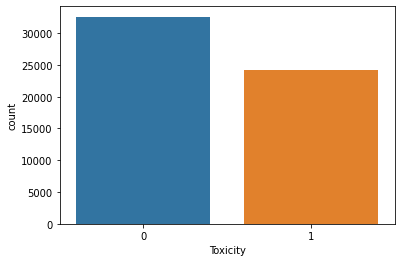

In [5]:
sns.countplot(x='Toxicity', data=data_df)

## View Random Data 

In [6]:
class_names = {0: "Non_Toxic", 1: "Toxic"}
for _ in range(10):
    random_index = np.random.randint(0,len(data_df))
    random_data = data_df.iloc[random_index]
    print(f"Target Label:{random_data['Toxicity']} ({class_names[random_data['Toxicity']]})")
    print(f"Tweet:\n{random_data['tweet']}")
    print("-------\n")


Target Label:1 (Toxic)
Tweet:
Gum drop looking bitch commenting on peoples looks
-------

Target Label:1 (Toxic)
Tweet:
smooth new year's eve! marijuana unleashed at ibooks.   
-------

Target Label:0 (Non_Toxic)
Tweet:
happy fathers day. you are love of my life &amp;the best father in the world. â¤ï¸ð @user #fathersday #love   
-------

Target Label:0 (Non_Toxic)
Tweet:
for those of us who lost our wonderful dads too soon, this hard day is almost over. ð  #fathersday  
-------

Target Label:0 (Non_Toxic)
Tweet:
.@user if only you'd have gone after #crookedhillary sooner; now you'll spend rest of your life asking yourself "what if.."  
-------

Target Label:1 (Toxic)
Tweet:
@_dinora_e jk i would be a bitch if i got them done !
-------

Target Label:1 (Toxic)
Tweet:
thirsty ass bitches shit dat ion like...
-------

Target Label:0 (Non_Toxic)
Tweet:
#blowoutsbringhappiness yet another   client! have you booked your appointment atâ¦ 
-------

Target Label:0 (Non_Toxic)
Tweet:
had

In [7]:
import re
X = [re.sub('http://\S+|https://\S+', '', text) for text in data_df['tweet']]
y = data_df['Toxicity'].values

In [8]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(np.array(X),
                                                                            np.array(y),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [9]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(51070, 5675, 51070, 5675)

In [10]:
train_sentences[:10], train_labels[:10]

(array(['No more SnapChat Selfies. No more Instagram Selfies. No more NOTHING i WILL NOT be a bad bitch a week man what am I going to do &#128546;&#128299;',
        "@c_drew_ I'm guessing so. The players are talking trash.",
        'RT @RihannaHasAids: if I got hoes.. @ one of my hoes.. if not shutup &amp; never say it again',
        ' @user @user @user now with  your guy bailing after meeting with the doj, that tells us indictment is unlikely.   #â\x80¦',
        'thank god for another day#dailyappreciation  wednesday everyone!!!!!!!',
        'your word i have treasured in my hea. (psalm 119:11) #vlicobs #xoxo #love #grace   #amenâ\x80¦ ',
        "RT @Gook____: Lil stupid ass bitch I don't fuck with YOU!!&#128564;",
        "RT @TreySongzSon: I'm in yo hood I'll prolly fuck yo hoe",
        '- i learned not to mourn so not woh !!  life is too sho to waste time on trifles !!    :p :) :d',
        "i hope the guy won't say how come  only trump gets to speak his mind ð\x9f\x98\xad..

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

2022-09-28 14:08:54.643313: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



We've initialized a `TextVectorization` object with the default settings but let's customize it a little bit for our own use case.

In particular, let's set values for `max_tokens` and `output_sequence_length`.

For `max_tokens` (the number of words in the vocabulary), multiples of 10,000 (10,000, 20,000, 30,000) or the exact number of unique words in your text (e.g. 32,179) are common values.

For our use case, we'll use 10,000.

And for the `output_sequence_length` we'll use the average number of tokens per Tweet in the training set. But first, we'll need to find it.

In [12]:

# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

14

In [13]:
max_vocab_length = 10000 
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

Beautiful!

To map our TextVectorization instance `text_vectorizer` to our data, we can call the `adapt()` method on it whilst passing it our training text.

In [14]:

# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

2022-09-28 14:08:55.243766: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [15]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 514,    4, 8584,   10,   12,  922,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [16]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'user', 'the', 'a']
Bottom 5 least common words: ['libra', 'lettuce', 'lettherainefall', 'letters', 'lethal']


Creating an Embedding using an Embedding Layer
We've got a way to map our text to numbers. How about we go a step further and turn those numbers into an embedding?

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. `1` = I, `2` = love, `3` = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the `tf.keras.layers.Embedding` layer.

The main parameters we're concerned about here are:

`input_dim` - The size of the vocabulary (e.g. len(text_vectorizer.get_vocabulary()).
`output_dim` - The size of the output embedding vector, for example, a value of 100 outputs a feature vector of size 100 for each word.
`embeddings_initializer` - How to initialize the embeddings matrix, default is "uniform" which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
`input_length` - Length of sequences being passed to embedding layer.
Knowing these, let's make an embedding layer.

In [17]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding


Excellent, notice how `embedding` is a TensoFlow layer? This is important because we can use it as part of a model, meaning its parameters (word representations) can be updated and improved as the model learns.

How about we try it out on a sample sentence?

In [18]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
  @user #girls winners of under 12/13 #girls #batharsenal tournament #wecanplay       

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02504804,  0.02770906,  0.01542609, ..., -0.04612003,
         -0.02924401, -0.00331711],
        [ 0.00163989,  0.01052092,  0.01279528, ..., -0.01638258,
          0.03507607, -0.01268239],
        [ 0.00874683, -0.03785013,  0.03305971, ...,  0.01537159,
          0.01672088,  0.04221293],
        ...,
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097]]], dtype=float32)>


These values might not mean much to us but they're what our computer sees each word as. When our model looks for patterns in different samples, these values will be updated as necessary.

# Create a Model 

## Model 1: 

Simplest Model with embedding which will be trained. 

`optimizer` : `Adam` 

`loss`: `binary_crossentropy`

In [19]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype = 'string') 
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')
model_1.compile(loss='binary_crossentropy',
               optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
               metrics = ["accuracy"])
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [20]:
history_1 = model_1.fit(train_sentences, train_labels,
           epochs =3,
           validation_data = (val_sentences, val_labels))


Epoch 1/3
1596/1596 [==============================] - 20s 12ms/step - loss: 0.2931 - accuracy: 0.8851 - val_loss: 0.2052 - val_accuracy: 0.9200
Epoch 2/3
1596/1596 [==============================] - 19s 12ms/step - loss: 0.1692 - accuracy: 0.9337 - val_loss: 0.1938 - val_accuracy: 0.9233
Epoch 3/3
1596/1596 [==============================] - 19s 12ms/step - loss: 0.1442 - accuracy: 0.9444 - val_loss: 0.2043 - val_accuracy: 0.9214


In [21]:
model_1_evaluate = model_1.evaluate(val_sentences, val_labels)

178/178 [==============================] - 0s 1ms/step - loss: 0.2043 - accuracy: 0.9214


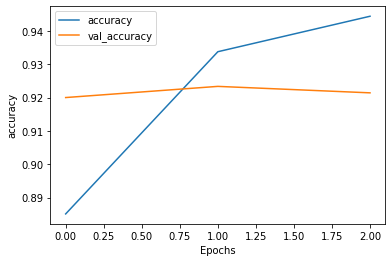

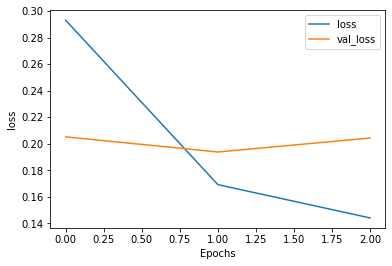

In [22]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history_1, "accuracy")
plot_graphs(history_1, "loss")

## Visualizing learned Embeddings

Our first model (`model_1`) contained an embedding layer (`embedding`) which learned a way of representing words as feature vectors by passing over the training data.

Hearing this for the first few times may sound confusing.

So to further help understand what a text embedding is, let's visualize the embedding our model learned.

And now let's get our embedding layer's weights (these are the numerical representations of each word).

In [23]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


Now we've got these two objects, we can use the [Embedding Projector tool](http://projector.tensorflow.org/) to visualize our embedding.

To use the Embedding Projector tool, we need two files:

The embedding vectors (same as embedding weights).
The meta data of the embedding vectors (the words they represent - our vocabulary).
Right now, we've got of these files as Python objects. To download them to file, we're going to [use the code example available on the TensorFlow word embeddings tutorial page.](https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk)

In [24]:
!ls ../working

__notebook__.ipynb


In [25]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("../working/embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("../working/embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

In [26]:
from IPython.display import FileLink
FileLink('embedding_vectors.tsv')

/kaggle/working/embedding_vectors.tsv

In [27]:
FileLink('embedding_metadata.tsv')

/kaggle/working/embedding_metadata.tsv


Once you've downloaded the embedding vectors and metadata, you can visualize them using Embedding Vector tool:

1. Go to http://projector.tensorflow.org/
2. Click on "Load data"
3. Upload the two files you downloaded (embedding_vectors.tsv and embedding_metadata.tsv)
4. Explore

Are words with similar meanings close together?

Remember, they might not be. The embeddings we downloaded are how our model interprets words, not necessarily how we interpret them.

Also, since the embedding has been learned purely from Tweets, it may contain some strange values as Tweets are a very unique style of natural language.

![](https://i.imgur.com/pVcrt2V.jpg)

You can see there are two dense parts one in left and another in right side. Are these our two classes `Toxicity` and `Non-Toxicity`. Yes, embeddings are learning words and positive words are getting one side and negative words going on negative side. 

There is possibility words are neutral those can be seen in between space.

# Model 2

In this model_2 we will try to use **RNN (Recurrent Neural Networks)**

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).


Recurrent Neural Networks (RNN's)
For our next series of modelling experiments we're going to be using a special kind of neural network called a Recurrent Neural Network (RNN).

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).

For example, when you read this sentence, you take into context the previous words when deciphering the meaning of the current word dog.

See what happened there?

I put the word "dog" at the end which is a valid word but it doesn't make sense in the context of the rest of the sentence.

When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence.

For a simple example, take two sentences:

Massive earthquake last week, no?
No massive earthquake last week.
Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:

1. **One to one:** one input, one output, such as image classification.
2. **One to many:** one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
3. **Many to one:** many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
4. **Many to many:** many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:

1. Long short-term memory cells (LSTMs).
2. Gated recurrent units (GRUs).
3. Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

In [28]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype = 'string') 
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs, name='model_2_dense')
model_2.compile(loss='binary_crossentropy',
               optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
               metrics = ["accuracy"])
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [29]:
history_2 = model_2.fit(train_sentences, train_labels,
           epochs =3,
           validation_data = (val_sentences, val_labels))


Epoch 1/3
1596/1596 [==============================] - 49s 29ms/step - loss: 0.1397 - accuracy: 0.9469 - val_loss: 0.1954 - val_accuracy: 0.9256
Epoch 2/3
1596/1596 [==============================] - 46s 29ms/step - loss: 0.1183 - accuracy: 0.9548 - val_loss: 0.2128 - val_accuracy: 0.9237
Epoch 3/3
1596/1596 [==============================] - 45s 28ms/step - loss: 0.0970 - accuracy: 0.9627 - val_loss: 0.2222 - val_accuracy: 0.9209


In [30]:
model_2_evaluate = model_2.evaluate(val_sentences, val_labels)
model_2_evaluate

178/178 [==============================] - 1s 7ms/step - loss: 0.2222 - accuracy: 0.9209


[0.22216130793094635, 0.9208810329437256]

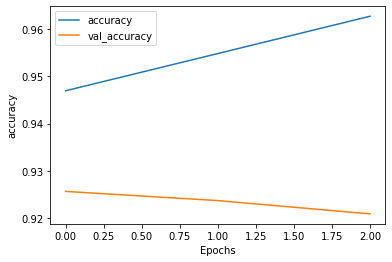

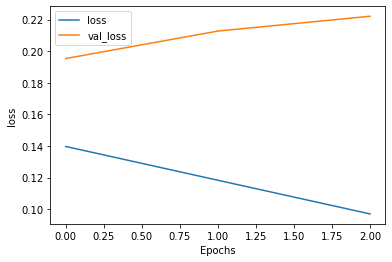

In [31]:
plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "loss")

# Model 3

Using Bidirectional RNN with LSTM.

In [32]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype = 'string') 
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(34))(x)
x = layers.Dense(16)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_2_dense')
model_3.compile(loss='binary_crossentropy',
               optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
               metrics = ["accuracy"])
model_3.summary()

Model: "model_2_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 68)                44336     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1104      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,325,457
Trainable params: 1,325,457
Non-trainable params: 0
___________________________________________

In [33]:
history_3 = model_3.fit(train_sentences, train_labels,
           epochs =3,
           validation_data = (val_sentences, val_labels))


Epoch 1/3
1596/1596 [==============================] - 62s 36ms/step - loss: 0.0955 - accuracy: 0.9641 - val_loss: 0.2455 - val_accuracy: 0.9207
Epoch 2/3
1596/1596 [==============================] - 56s 35ms/step - loss: 0.0660 - accuracy: 0.9746 - val_loss: 0.2731 - val_accuracy: 0.9186
Epoch 3/3
1596/1596 [==============================] - 56s 35ms/step - loss: 0.0498 - accuracy: 0.9812 - val_loss: 0.3242 - val_accuracy: 0.9144


In [34]:
model_3_evaluate = model_3.evaluate(val_sentences, val_labels)
model_3_evaluate

178/178 [==============================] - 2s 8ms/step - loss: 0.3242 - accuracy: 0.9144


[0.3242005705833435, 0.9143612384796143]

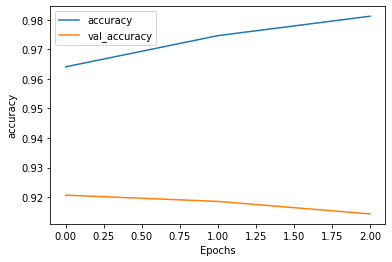

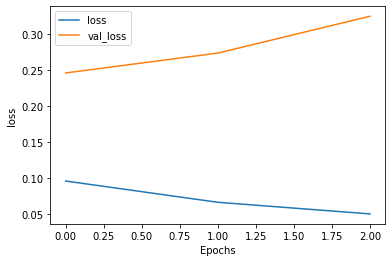

In [35]:
plot_graphs(history_3, "accuracy")
plot_graphs(history_3, "loss")

# Comparing Evaluation

In [36]:
evaluation_df = pd.DataFrame([model_1_evaluate, model_2_evaluate, model_3_evaluate], 
                                     columns = ["loss", "accuracy"],
                                    index = ['model_1', 'model_2', 'model_3'])
evaluation_df

,loss,accuracy
model_1,0.204329,0.921410
model_2,0.222161,0.920881
model_3,0.324201,0.914361


<AxesSubplot:ylabel='loss'>

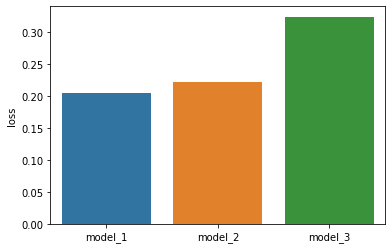

In [37]:
sns.barplot(data=evaluation_df, y='loss', x=evaluation_df.index)


<AxesSubplot:ylabel='accuracy'>

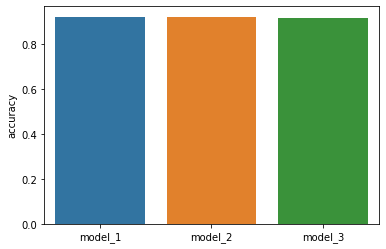

In [38]:
sns.barplot(data=evaluation_df, y='accuracy', x=evaluation_df.index)

As we can see Model_1 loss is lowest of all.  

Let's run predictions on model_1.

# Predictions

In [39]:
predictions = model_1.predict(val_sentences)
predictions[:5]

array([[2.0717326e-01],
       [3.0859828e-02],
       [9.9649429e-02],
       [9.9957329e-01],
       [6.0406327e-04]], dtype=float32)

Since our final layer uses a sigmoid activation function, we get our predictions back in the form of probabilities.

To convert them to prediction classes, we'll use `tf.round()`, meaning prediction probabilities below 0.5 will be rounded to 0 and those above 0.5 will be rounded to 1.

In [40]:
predictions_result = tf.cast(tf.squeeze(tf.round(predictions)),dtype = tf.int32)
predictions_result[:5]

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 0, 1, 0], dtype=int32)>

In [41]:
result_df = pd.DataFrame({"Tweets": val_sentences,'Toxicity': predictions_result})
result_df.head()

,Tweets,Toxicity
0,My dad just told @YourDudeFerg 's dad to text ...,0
1,omg tears #presumptivenominee @user #weareeq...,0
2,cancun for spring breakð¤ ....yes please! ð...,0
3,I guess I just come off as a bitch to people &...,1
4,she wasn't ready to die. too young. a young ag...,0
